In [2]:
import numpy as np
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
CHANNELS = 10
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset', 
    shuffle=True, 
    image_size=(IMAGE_SIZE,IMAGE_SIZE), 
    batch_size=BATCH_SIZE)

Found 16011 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names

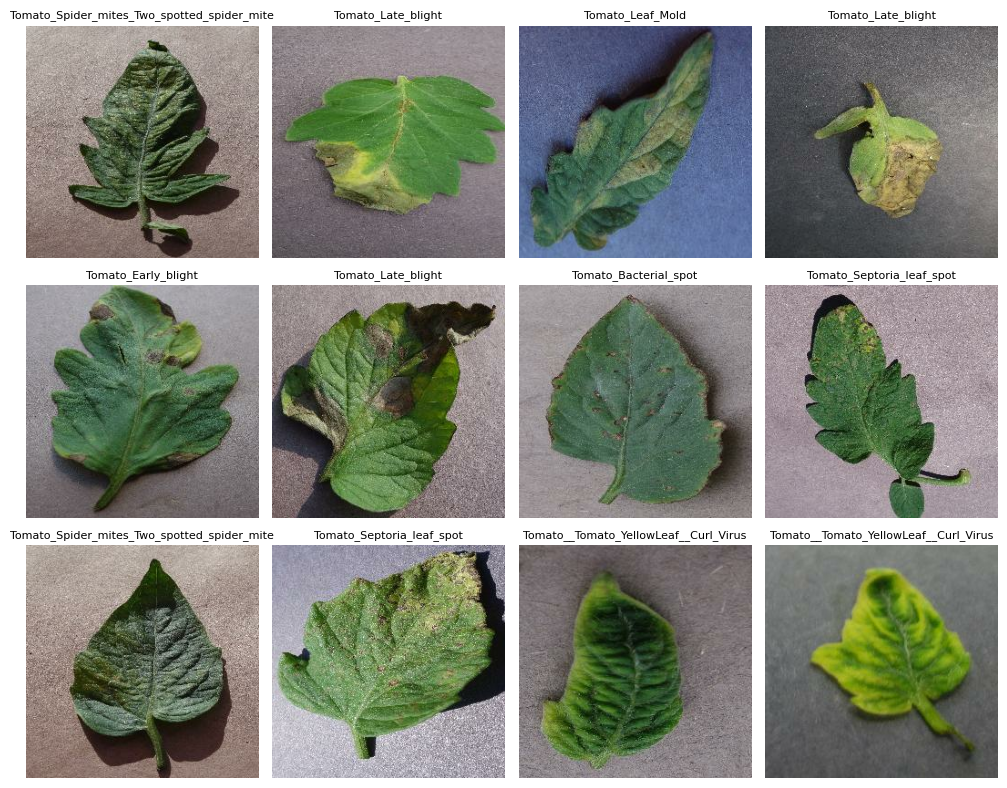

In [14]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10, 8))
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # 3 rows and 4 columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()],fontsize=8)
        plt.axis("off")
    
    plt.tight_layout(pad=1)
    plt.show()

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

400

In [18]:
len(val_ds)

50

In [19]:
len(test_ds)

51

In [20]:
len(dataset)

501

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)
# print(input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
400/400 [==============================] - 116s 205ms/step - loss: 1.7053 - accuracy: 0.3957 - val_loss: 1.4681 - val_accuracy: 0.5094
Epoch 2/50
400/400 [==============================] - 58s 146ms/step - loss: 1.0861 - accuracy: 0.6128 - val_loss: 1.2103 - val_accuracy: 0.5537
Epoch 3/50
400/400 [==============================] - 22s 55ms/step - loss: 0.8180 - accuracy: 0.7070 - val_loss: 1.1161 - val_accuracy: 0.6212
Epoch 4/50
400/400 [==============================] - 21s 53ms/step - loss: 0.5832 - accuracy: 0.7890 - val_loss: 1.1865 - val_accuracy: 0.6744
Epoch 5/50
400/400 [==============================] - 21s 53ms/step - loss: 0.4639 - accuracy: 0.8370 - val_loss: 1.7155 - val_accuracy: 0.6150
Epoch 6/50
400/400 [==============================] - 21s 52ms/step - loss: 0.4002 - accuracy: 0.8587 - val_loss: 0.7526 - val_accuracy: 0.7750
Epoch 7/50
400/400 [==============================] - 21s 53ms/step - loss: 0.3681 - accuracy: 0.8690 - val_loss: 0.6224 - val_accura

In [28]:
model.save('demo_model.h5')

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

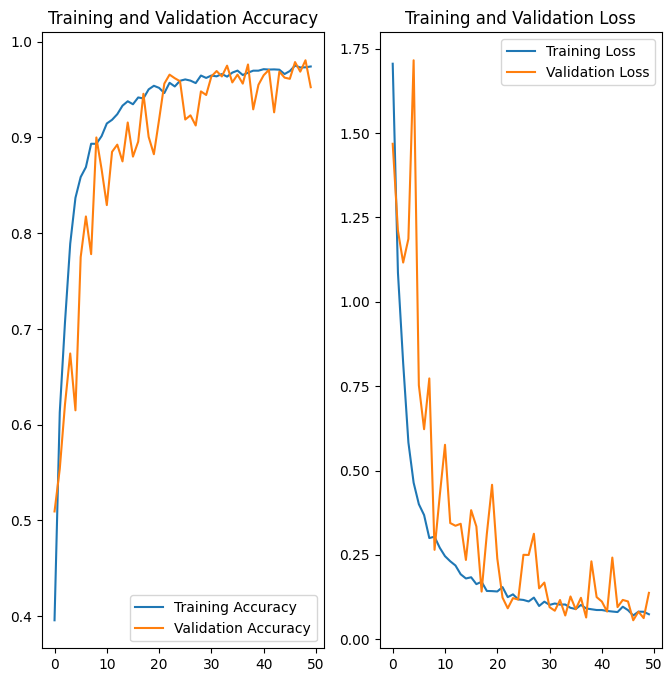

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Tomato_healthy
predicted label: Tomato_healthy


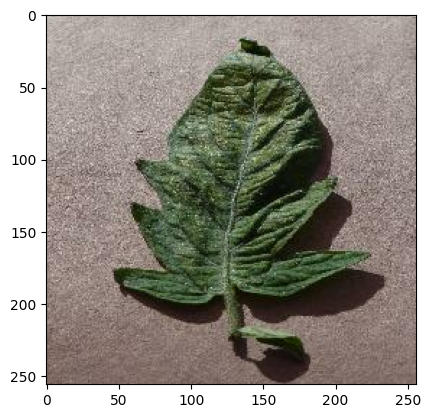

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

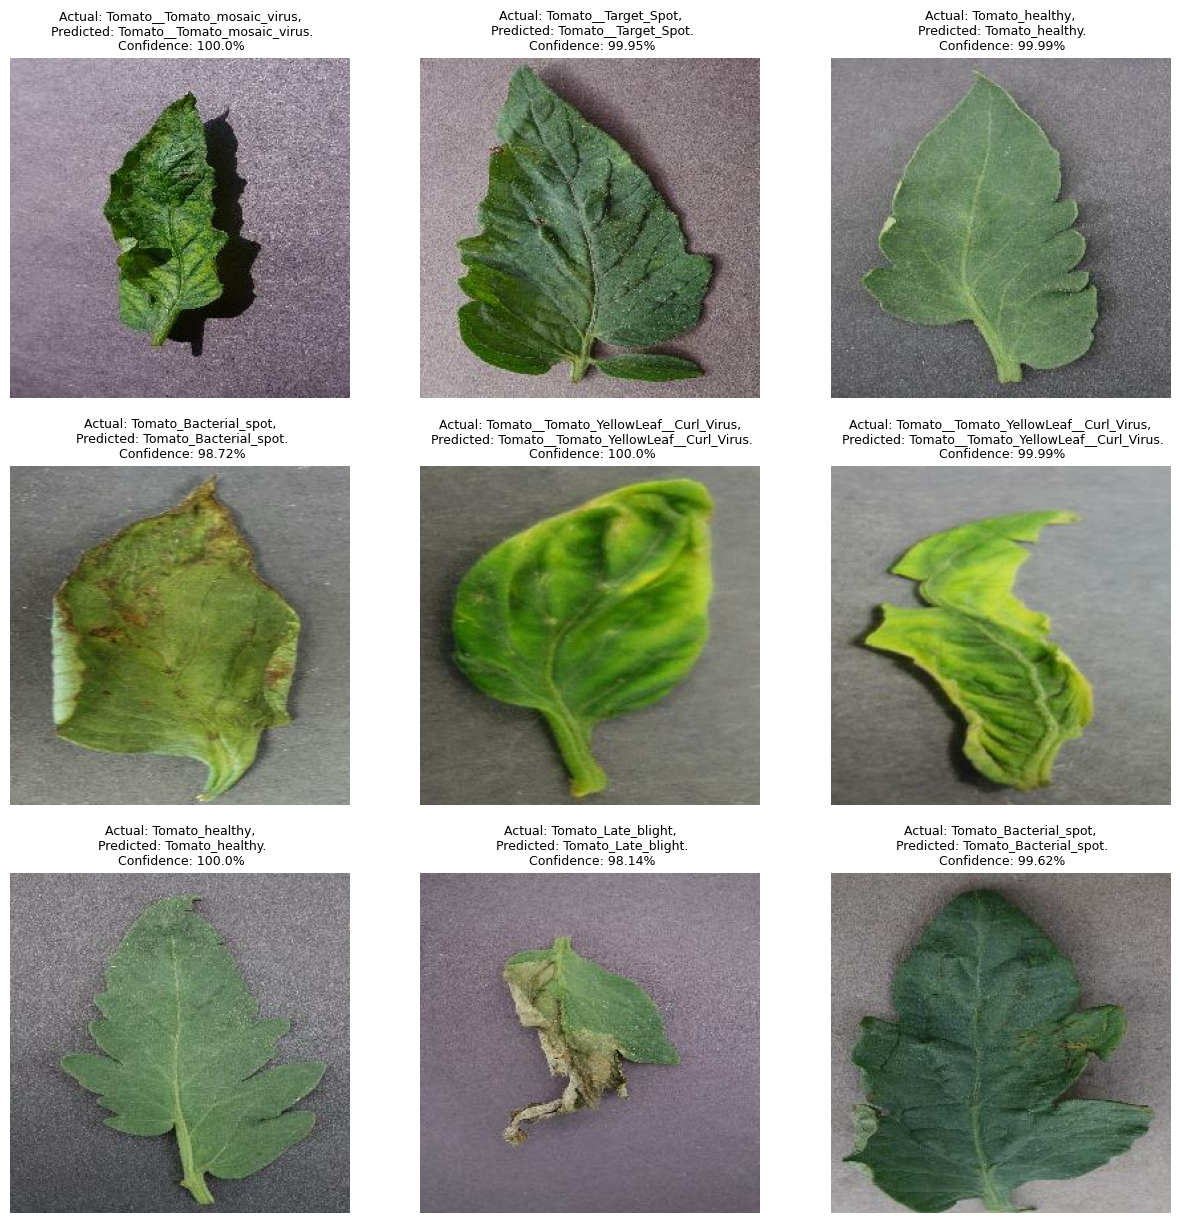

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=9)
        
        plt.axis("off")

In [1]:
#ya manually bhi kisi bhi name se save kr sakta hai but isse har bar run krega toh wo new model verion(1,2,3..) save krdega
# import os
# model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1

In [2]:
# model.save(f"../models/{model_version}")